XGB Classifier

Best score 0.89

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [3]:
train = pd.read_csv('../Data/train_with_BMI.csv')
test = pd.read_csv('../Data/test_with_BMI.csv')
val = pd.read_csv('../Data/val_with_BMI.csv')

In [4]:
X_train = train.drop('NObeyesdad', axis=1)
y_train = train['NObeyesdad']
X_test = test.drop('NObeyesdad', axis=1)
y_test = test['NObeyesdad']
X_val = val.drop('NObeyesdad', axis=1)
y_val = val['NObeyesdad']

In [6]:
param_grid = {
    'max_depth': [ 4, 5, 7],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 500, 1000],
    'subsample': [0.5, 0.75, 1.0],
    'colsample_bytree': [0.5, 0.75, 1.0],
}


xgb = XGBClassifier()


grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)


grid_search.fit(X_train, y_train)


print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

Fitting 3 folds for each of 1620 candidates, totalling 4860 fits


[CV] END colsample_bytree=0.5, gamma=0.5, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.5, gamma=0.5, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.75; total time=   1.6s
[CV] END colsample_bytree=0.5, gamma=0.5, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.5; total time=   1.7s
[CV] END colsample_bytree=0.5, gamma=0.5, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.5; total time=   1.7s
[CV] END colsample_bytree=0.5, gamma=0.5, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.75; total time=   1.7s
[CV] END colsample_bytree=0.5, gamma=0.5, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.5, gamma=0.5, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.5; total time=   1.8s
[CV] END colsample_bytree=0.5, gamma=0.5, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.75; 

Best parameters found:  {'colsample_bytree': 0.5, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 1000, 'subsample': 0.75}
Best score found:  0.8903649746550352

In [5]:
final_model = XGBClassifier(random_state = 1, colsample_bytree = 0.5, learning_rate = 0.01, max_depth = 7, n_estimators = 1000, 
                            subsample = 0.75, gamma = 0.5)
final_model.fit(X_train, y_train)
pred = final_model.predict(X_val)

print('Classification report:\n' , classification_report(y_val, pred))
print('Confusion matrix: \n', confusion_matrix(y_val, pred))

Classification report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       525
           1       0.85      0.88      0.87       624
           2       0.88      0.84      0.86       604
           3       0.96      0.97      0.96       714
           4       0.99      1.00      0.99       837
           5       0.77      0.75      0.76       532
           6       0.76      0.77      0.76       523

    accuracy                           0.89      4359
   macro avg       0.88      0.88      0.88      4359
weighted avg       0.89      0.89      0.89      4359

Confusion matrix: 
 [[482  37   0   0   0   4   2]
 [ 27 551   1   0   0  37   8]
 [  2   2 508  23   5  25  39]
 [  0   0  15 692   1   0   6]
 [  1   0   1   1 834   0   0]
 [  0  43  13   0   1 401  74]
 [  0  14  41   8   0  57 403]]


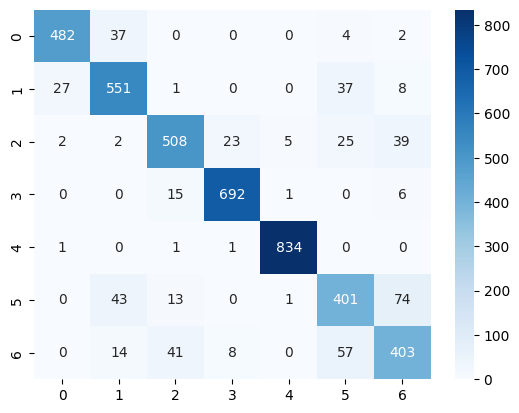

<Figure size 640x480 with 0 Axes>

In [10]:
#draw confusion matrix:
cm = confusion_matrix(y_val, pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()
plt.savefig('../Images/XGBoost_train_confusion_matrix.png')
